In [1]:
from difflogic import PairedLogicLayer, InvLogicLayer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [ ]:
class AndLogicLayer(nn.Module):
    def __init__(self, size=28*28):
        super(AndLogicLayer, self).__init__()
        self.weights = nn.Parameter(torch.zeros(size).to('cuda'))

    def forward(self, x):
        # do and operation on the input
        output = x * self.weights
        sum = torch.sum(output, dim=1)
        output = torch.tanh(sum)
        return output

# Weighting between all of the ghost images for a given class
class FinalLayer(nn.Module):
    def __init__(self, ghosts_per_class=4):
        super(FinalLayer, self).__init__()
        self.biases = torch.tensor(self.normalized_linear_biases(n=ghosts_per_class)).to('cuda')
        self.weights = nn.Parameter(torch.ones(ghosts_per_class).to('cuda'))

    def normalize_biases(self, biases):
        biases = np.array(biases, dtype=np.float64)
        total = np.sum(biases)
        if total == 0:
            raise ValueError("Bias sum is zero — can't normalize.")
        return biases / total
    
    def normalized_linear_biases(self, n, start=1.0, end=0.1):
        raw = np.linspace(start, end, num=n)
        return self.normalize_biases(raw)
    
    def forward(self, x):
        # Weighted average of the ghost outputs using the biases
        x = x * self.weights
        x = x + self.biases
        x = torch.mean(x, dim=1)
        return x


class GhostNet(nn.Module):
    def __init__(self, size=28*28):
        super(GhostNet, self).__init__()
        self.size = size
        self.blank_image = torch.zeros(size).unsqueeze(0).to('cuda')
        self.invert = InvLogicLayer(int(size), int(size), restricted_gates=[3,12], implementation='python')
        self.xor = PairedLogicLayer(int(size*2), int(size), restricted_gates=[9], implementation='python')
        self.and_gate = AndLogicLayer()
    def forward(self, x): 
        y = x.squeeze(1).reshape(-1, self.size).to('cuda')
        z = self.invert(self.blank_image.repeat((y.shape[0], 1)))
        z = self.xor(torch.cat((y, z), dim=1))
        z = self.and_gate(z)
        return z

class MultiMassGhostNet(nn.Module):
    def __init__(self, num_classes=10, ghosts_per_class=4, size=28*28):
        super(MultiMassGhostNet, self).__init__()
        self.num_classes = num_classes
        self.ghosts_per_class = ghosts_per_class
        self.size = size
        self.ghosts = nn.ModuleList([GhostNet(size) for _ in range(num_classes * ghosts_per_class)])
        self.final_layer = FinalLayer(ghosts_per_class)

    def forward(self, x):
        outputs = []
        # Loop through by class, get ghosts_per_class outputs, and pass them into final_layer
        for i in range(self.num_classes):
            # Get the ghost nets for this class
            ghosts = self.ghosts[i * self.ghosts_per_class:(i + 1) * self.ghosts_per_class]
            # Apply each ghost net to the input
            class_outputs = [ghost(x) for ghost in ghosts]
            ghost_outputs = torch.stack(class_outputs, dim=1)
            final_output = self.final_layer(ghost_outputs)
            outputs.append(final_output)

        return torch.stack(outputs, dim=1)


In [ ]:
# Try to train the model
import torch.nn.functional as F
net = MultiMassGhostNet()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data.to('cuda'))
        # Convert target to a one-hot encoded tensor
        target = F.one_hot(target, num_classes=10).float()
        loss = loss_fn(output, target.to('cuda').float())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data.to('cuda'))
            target_2 = F.one_hot(target, num_classes=10).float()
            test_loss += loss_fn(output, target_2.to('cuda').float()).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

In [74]:
for epoch in range(1, 5):
    train(epoch)
    test()

Train Epoch: 1 [0/60000] Loss: 2.302585
Train Epoch: 1 [6400/60000] Loss: 1.129628
Train Epoch: 1 [12800/60000] Loss: 1.024280
Train Epoch: 1 [19200/60000] Loss: 0.796839
Train Epoch: 1 [25600/60000] Loss: 0.849430
Train Epoch: 1 [32000/60000] Loss: 0.698448
Train Epoch: 1 [38400/60000] Loss: 0.580467
Train Epoch: 1 [44800/60000] Loss: 0.587291
Train Epoch: 1 [51200/60000] Loss: 0.554810
Train Epoch: 1 [57600/60000] Loss: 0.538108
Test set: Average loss: 0.0133, Accuracy: 8964/10000 (90%)
Train Epoch: 2 [0/60000] Loss: 0.518111
Train Epoch: 2 [6400/60000] Loss: 0.560650
Train Epoch: 2 [12800/60000] Loss: 0.580357
Train Epoch: 2 [19200/60000] Loss: 0.452166
Train Epoch: 2 [25600/60000] Loss: 0.395430
Train Epoch: 2 [32000/60000] Loss: 0.366687
Train Epoch: 2 [38400/60000] Loss: 0.368733
Train Epoch: 2 [44800/60000] Loss: 0.267103
Train Epoch: 2 [51200/60000] Loss: 0.285011
Train Epoch: 2 [57600/60000] Loss: 0.520372
Test set: Average loss: 0.0123, Accuracy: 8924/10000 (89%)
Train Epoch:

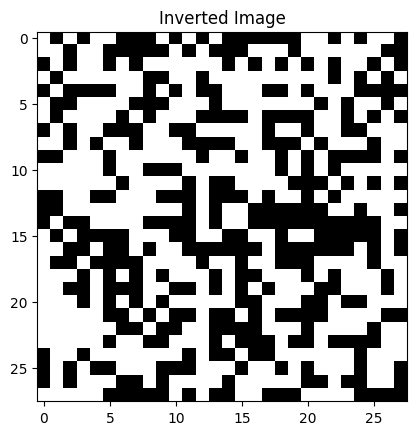

In [91]:
# Visualize the positive and negative images for each class
# Pass the blank_image into inverters
ghost_image = net.ghosts[0].invert(net.ghosts[0].blank_image).cpu().detach().numpy()
plt.imshow(ghost_image.reshape(28, 28), cmap='gray')
plt.title('Inverted Image')

# Convert the 0s to -1s
ghost_image[ghost_image == 0] = -1

ghost_image = torch.tensor(ghost_image).to('cuda')

Text(0.5, 1.0, 'AND Weights')

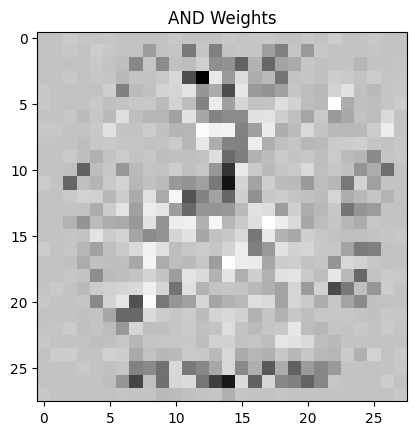

In [99]:
# Get AND weights
and_weights = net.ghosts[16].and_gate.weights.cpu().detach().numpy()

# Visualize weights
plt.imshow(and_weights.reshape(28, 28), cmap='gray')
plt.title('AND Weights')

Text(0.5, 1.0, 'AND Weights')

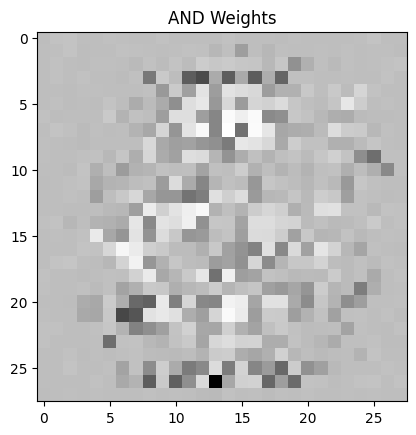

In [100]:
# Get AND weights
and_weights = net.ghosts[17].and_gate.weights.cpu().detach().numpy()

# Visualize weights
plt.imshow(and_weights.reshape(28, 28), cmap='gray')
plt.title('AND Weights')

Text(0.5, 1.0, 'AND Weights')

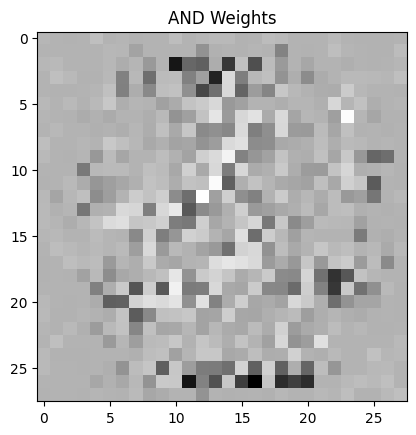

In [101]:
# Get AND weights
and_weights = net.ghosts[18].and_gate.weights.cpu().detach().numpy()

# Visualize weights
plt.imshow(and_weights.reshape(28, 28), cmap='gray')
plt.title('AND Weights')

Text(0.5, 1.0, 'AND Weights')

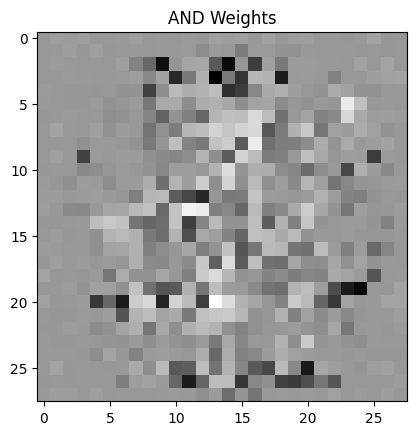

In [102]:
# Get AND weights
and_weights = net.ghosts[19].and_gate.weights.cpu().detach().numpy()

# Visualize weights
plt.imshow(and_weights.reshape(28, 28), cmap='gray')
plt.title('AND Weights')